In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import shap

In [7]:
df = pd.read_csv("../data/raw/bank/bank-full.csv",sep=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
print('JOB:',df['job'].unique())
print('MARITAL:',df['marital'].unique())
print('education:',df['education'].unique())
print('default:',df['default'].unique())
print('housing:',df['housing'].unique())
print('loan:',df['loan'].unique())
print('contact:',df['contact'].unique())
print('month:',df['month'].unique())
print('day_of_week:',df['day_of_week'].unique())
print('poutcome:',df['poutcome'].unique())
print('y:',df['y'].unique())

JOB: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
MARITAL: ['married' 'single' 'divorced' 'unknown']
education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default: ['no' 'unknown' 'yes']
housing: ['no' 'yes' 'unknown']
loan: ['no' 'yes' 'unknown']
contact: ['telephone' 'cellular']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome: ['nonexistent' 'failure' 'success']
y: ['no' 'yes']


In [8]:
coded_df = df

# Make sure all categorical variables are of string type
categorical_cols = ["job", "marital", "education", "default", "housing", "loan",
                    "contact", "month", "day_of_week", "poutcome"]
coded_df[categorical_cols] = coded_df[categorical_cols].astype(str)

# 1. Handling binary variables (default, housing, loan)
binary_cols = ["default", "housing", "loan", "contact", "poutcome"]
for col in binary_cols:
    if col == "contact":
        coded_df[col] = coded_df[col].map({"telephone": 1, "cellular": 0})
    elif col == "poutcome":
        coded_df[col] = coded_df[col].map({"nonexistent": 0, "failure": -1, "success": 1})
    else:
        coded_df[col] = coded_df[col].map({"no": 0, "yes": 1, "unknown": -1})  # Handling unknown values

# 2. deal with time variable(month, day_of_week)
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}

# Mapping Values
coded_df["month"] = coded_df["month"].map(month_mapping)
coded_df["day_of_week"] = coded_df["day_of_week"].map(day_mapping)

# 3. One-Hot Encoding of the remaining categorical variables
onehot_cols = ["job", "marital", "education"]
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")
encoded_features = encoder.fit_transform(coded_df[onehot_cols])

# Creating One-Hot DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(onehot_cols))

# 4. Merge One-Hot Encoded Data
coded_df = coded_df.drop(columns=onehot_cols).reset_index(drop=True)
coded_df = pd.concat([coded_df, encoded_df], axis=1)

# 5. Target variable encoding
coded_df["y"] = coded_df["y"].map({"no": 0, "yes": 1})

coded_df.to_csv("bank_processed.csv", index=False)

# 6. View the encoded data
coded_df.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,...,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,56,0,0,0,1,5,1,261,1,999,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,-1,0,0,1,5,1,149,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37,0,1,0,1,5,1,226,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,40,0,0,0,1,5,1,151,1,999,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56,0,0,1,1,5,1,307,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# Split features (X) and target variable (y)
X = coded_df.drop(columns=["y"])
y = coded_df["y"]

# 80% training set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [14]:
# Defining the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Suitable for binary classification tasks
    eval_metric="logloss",  # Evaluation indicators
)

# model training
xgb_clf.fit(X_train, y_train)

# predict
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuary: {acc:.4f}")

XGBoost Accuary: 0.9160


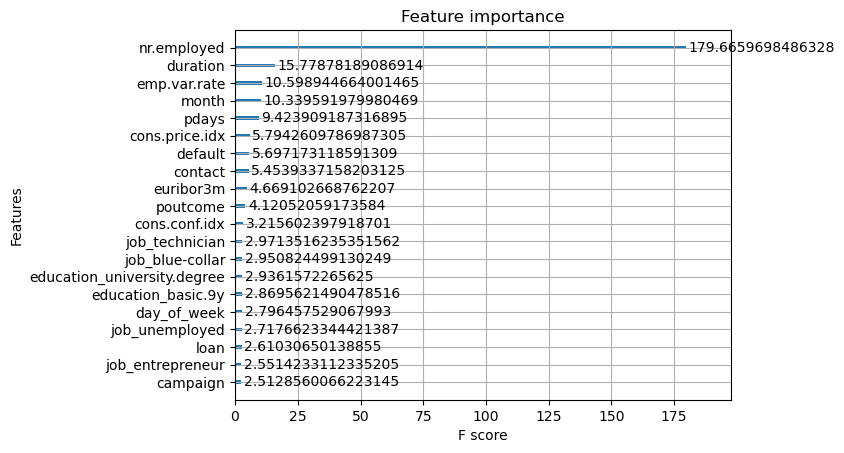

In [13]:
xgb.plot_importance(xgb_clf, importance_type="gain", max_num_features=20)  # top 20 features
plt.show()